In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/MyDrive/Kvasir'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import os
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [5]:
BATCH_SIZE = 64

train_datagen = image.ImageDataGenerator(rescale=1./255, rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True, validation_split=0.222)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [6]:
#Defining paths
TRAIN_PATH = "/content/drive/MyDrive/Kvasir/Train"
TEST_PATH = "/content/drive/MyDrive/Kvasir/Test"

In [7]:
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 5608 images belonging to 8 classes.
Found 1592 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [8]:
from keras.metrics import top_k_categorical_accuracy
def top_5_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', top_5_categorical_accuracy])

In [10]:
#summarizing the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 128)     36992     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

In [11]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [12]:
model_history = model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=30,
                            validation_data=validation_generator,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/30
88/88 [==============================] - ETA: 0s - loss: 1.7370 - accuracy: 0.2919 - top_5_categorical_accuracy: 0.8948 
Epoch 1: val_loss improved from inf to 1.36607, saving model to tl_model_v1.weights.best.hdf5
88/88 [==============================] - 1982s 22s/step - loss: 1.7370 - accuracy: 0.2919 - top_5_categorical_accuracy: 0.8948 - val_loss: 1.3661 - val_accuracy: 0.3700 - val_top_5_categorical_accuracy: 0.9786
Epoch 2/30
88/88 [==============================] - ETA: 0s - loss: 1.3654 - accuracy: 0.3793 - top_5_categorical_accuracy: 0.9700
Epoch 2: val_loss improved from 1.36607 to 1.10936, saving model to tl_model_v1.weights.best.hdf5
88/88 [==============================] - 263s 3s/step - loss: 1.3654 - accuracy: 0.3793 - top_5_categorical_accuracy: 0.9700 - val_loss: 1.1094 - val_accuracy: 0.4975 - val_top_5_categorical_accuracy: 0.9899
Epoch 3/30
88/88 [==============================] - ETA: 0s - loss: 1.2070 - accuracy: 0.4463 - top_5_categorical_accuracy: 0.9

In [13]:
# Generate predictions
model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

model_preds = model.predict(test_generator)
model_pred_classes = np.argmax(model_preds, axis=1)

In [15]:
from sklearn.metrics import accuracy_score

model_acc = accuracy_score(true_classes, model_pred_classes)
print("CNN Model's Top 1% Accuracy: {:.2f}%".format(model_acc * 100))

CNN Model's Top 1% Accuracy: 58.63%


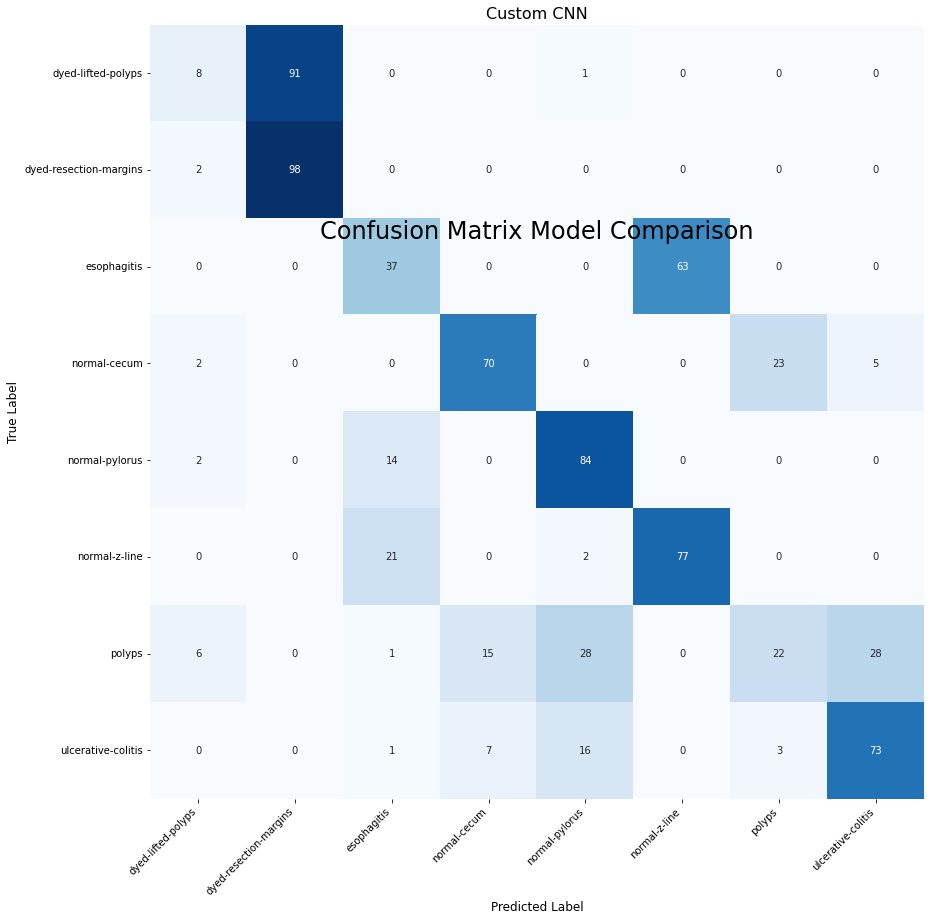

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(figsize=(20, 10))

plot_heatmap(true_classes, model_pred_classes, class_names, ax1, title="Custom CNN")    
fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()